### ANN (Padded Generator matrix encoded)

In [1]:
%reset -f
import gc
gc.collect()

0

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 16
q = 5
num_samples = 1000

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [3]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [4]:
def padded_generator_matrix(n, w0, z0):
    zeta = np.exp(-2j * np.pi / n)
    M_tilde = np.array([[(w0 / z0) ** j * zeta**(k * j) for j in range(n)] for k in range(n)], dtype=complex)
    return M_tilde

In [5]:
# (x, y, z, w) --> (1, 2, 3, 4)
w0 = 4
z0 = 3

M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(16, 16)


In [6]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[ 649.89449698  +0.j           69.97998169+371.13335899j
   -83.92481787+137.40000024j ...  -88.37954911-103.22398682j
   -83.92481787-137.40000024j   69.97998169-371.13335899j]
 [ 695.87003951  +0.j          268.59479107+394.57072111j
   -36.50274968+309.16102475j ...  -47.36788425-179.88976988j
   -36.50274968-309.16102475j  268.59479107-394.57072111j]
 [ 540.63797786  +0.j          235.29809241+209.31041098j
   176.66145652+204.71795948j ...  108.87153914-320.22828928j
   176.66145652-204.71795948j  235.29809241-209.31041098j]
 ...
 [ 460.45123158  +0.j          162.64910275+168.11969395j
    54.45039471+219.81284778j ...  -26.91067254-124.72256855j
    54.45039471-219.81284778j  162.64910275-168.11969395j]
 [ 558.17613119  +0.j          -92.41727316+362.85897707j
  -228.64175513 +13.85662093j ...  -76.51498185+176.39278765j
  -228.64175513 -13.85662093j  -92.41727316-362.85897707j]
 [ 671.99178181  +0.j          161.97417378+352.04621278j
    43.09272997+244.01831359j ...  -56.208

In [7]:
print(encoded_dataset.shape)

(1000, 16)


In [8]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[ 649.89449698  +0.j           69.97998169+371.13335899j
  -83.92481787+137.40000024j  -88.37954911+103.22398682j
  -74.53901813 +41.73652084j  -97.48254893 +37.96448017j
 -147.95858217-108.15626408j   47.97234649-148.66691513j
  146.76987906  -0.j           47.97234649+148.66691513j
 -147.95858217+108.15626408j  -97.48254893 -37.96448017j
  -74.53901813 -41.73652084j  -88.37954911-103.22398682j
  -83.92481787-137.40000024j   69.97998169-371.13335899j]


In [9]:
####### Method 1 ########

# Stack real/imaginary parts
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)
X_real_imag = np.hstack([X_real, X_imag])

print("\nX_train_real :", X_real.shape)
print(X_real[0])
print("\nX_train_imag :", X_imag.shape)
print(X_imag[0])
print("\nX_train :", X_real_imag.shape)
print(X_real_imag[0])


X_train_real : (1000, 16)
[ 649.8945     69.97998   -83.92482   -88.37955   -74.53902   -97.48255
 -147.95859    47.972347  146.76988    47.972347 -147.95859   -97.48255
  -74.53902   -88.37955   -83.92482    69.97998 ]

X_train_imag : (1000, 16)
[   0.        371.13336   137.4       103.22398    41.736523   37.96448
 -108.156265 -148.66692    -0.        148.66692   108.156265  -37.96448
  -41.736523 -103.22398  -137.4      -371.13336 ]

X_train : (1000, 32)
[ 649.8945     69.97998   -83.92482   -88.37955   -74.53902   -97.48255
 -147.95859    47.972347  146.76988    47.972347 -147.95859   -97.48255
  -74.53902   -88.37955   -83.92482    69.97998     0.        371.13336
  137.4       103.22398    41.736523   37.96448  -108.156265 -148.66692
   -0.        148.66692   108.156265  -37.96448   -41.736523 -103.22398
 -137.4      -371.13336 ]


In [10]:
# # normalize x values before feeding to the model cause they are a bit large

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_real_imag = scaler.fit_transform(X_real_imag)

# print("\nX_train after scaling:", X_real_imag.shape)
# print(X_real_imag[0])

In [11]:
# normalize target data (integers 0-q to [0, 1])
y_normalized = dataset.astype(np.float32) / (q - 1)  # Scale to [0, 1]
print("y: ")
print(dataset.astype(np.float32)[0])
print("\ny_normalized: ")
print(y_normalized[0])

labels = y_normalized

y: 
[3. 4. 2. 4. 4. 1. 2. 2. 2. 4. 3. 2. 4. 1. 3. 1.]

y_normalized: 
[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [12]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_real_imag, labels, test_size=0.2, random_state=42
)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (800, 32) (800, 16)
Testing data shape: (200, 32) (200, 16)


In [13]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

32
16


Simple Feedforward Neural Network

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))

def mse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))
    cos_part = cosine_loss(y_true, y_pred)
    return 0.5 * mse_part + 0.5 * cos_part


def simple_NN(input_dim, output_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(n*2, activation=activation),
        Dense(n*2, activation=activation),
        Dense(n*2, activation=activation),
        # Dense(n*2, activation=activation),
        Dense(output_dim, activation='linear')  # Linear activation for regression
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=hybrid_loss, #'mean_squared_error', # Huber(delta=1.0)
        metrics=['mse', 'mae']
    )
    return model


input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = simple_NN(input_dim, output_dim, activation='leaky_relu')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
Total params: 3696 (14.44 KB)
Trainable params: 3696 (14.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

dense (None, 32)
dense_1 (None, 32)
dense_2 (None, 32)
dense_3 (None, 16)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',  # You can change this to 'loss' if you prefer training loss
    factor=0.5,          # Reduce learning rate by this factor
    patience=5,          # Number of epochs with no improvement before reducing LR
    min_lr=1e-7,         # Minimum learning rate
    verbose=1            # Print updates
)

In [17]:
# train
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500


50/50 [==============================] - 4s 24ms/step - loss: 1240.6930 - mse: 2480.3491 - mae: 30.2635 - val_loss: 125.3505 - val_mse: 249.7336 - val_mae: 12.2976 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 77.9744 - mse: 154.9789 - mae: 9.6802 - val_loss: 64.2800 - val_mse: 127.5536 - val_mae: 8.7862 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 0s 7ms/step - loss: 43.7171 - mse: 86.4680 - mae: 7.2456 - val_loss: 40.5721 - val_mse: 80.1813 - val_mae: 6.9647 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 0s 7ms/step - loss: 29.1327 - mse: 57.3216 - mae: 5.8941 - val_loss: 28.3215 - val_mse: 55.6853 - val_mae: 5.7923 - lr: 0.0010
Epoch 5/500
50/50 [==============================] - 0s 6ms/step - loss: 21.3288 - mse: 41.7244 - mae: 5.0369 - val_loss: 21.5095 - val_mse: 42.0764 - val_mae: 5.0183 - lr: 0.0010
Epoch 6/500
50/50 [==============================] - 0s 6ms/step - loss: 16.5938 - mse:

In [18]:
# evaluate
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0325 - mse: 0.0288 - mae: 0.1138
Test MSE: 0.0288, Test MAE: 0.1138


In [19]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_ANN_history.csv', index=False)

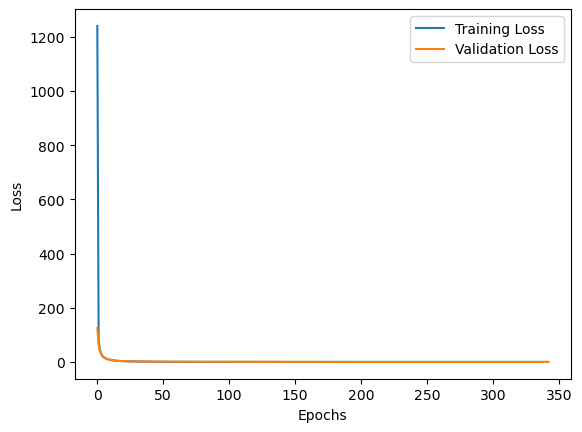

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def decode_predictions(predictions, q=8):
    # denormalize and round to nearest integer
    decoded = np.round(predictions * (q - 1)).astype(int)
    # clip values to ensure they are within [0, q-1]
    decoded = np.clip(decoded, 0, q-1)
    return decoded

# samples
sample_indices = np.random.choice(len(X_test), 3)
sample_X = X_test[sample_indices]
sample_y_true = y_test[sample_indices]

# Predict and decode
sample_y_pred = model.predict(sample_X)
sample_y_pred_decoded = decode_predictions(sample_y_pred)

# Compare with ground truth
print("\nSample Predictions:")
for i in range(len(sample_indices)):
    print(f"Sample {i+1}:")
    print("Original :", np.round(sample_y_true[i] * (q-1)).astype(int))
    print("Predicted:", sample_y_pred_decoded[i])
    print()

1/1 [==============================] - 0s 267ms/step

Sample Predictions:
Sample 1:
Original : [3 0 1 1 3 0 1 0 0 0 4 0 4 3 1 1]
Predicted: [4 1 3 4 5 1 1 0 0 0 6 0 6 6 2 2]

Sample 2:
Original : [0 4 0 1 4 3 4 4 3 3 1 3 2 2 1 0]
Predicted: [3 5 2 1 4 5 7 6 5 5 1 5 4 3 2 0]

Sample 3:
Original : [4 2 4 2 1 3 0 3 0 4 4 0 3 0 1 4]
Predicted: [4 3 5 3 3 5 0 6 0 7 7 0 5 0 2 7]

